# Qiskit code for estimating tasks and shots for LiH groundstate

In [2]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

import numpy as np
# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator as AerEstimator

In [3]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()

    fermionic_op = problem.hamiltonian.second_q_op()
    
    #mapper_jw = JordanWignerMapper()
    #qubit_jw_op = mapper_jw.map(fermionic_op)
    
    mapper_par = ParityMapper(num_particles=problem.num_particles)
    qubit_op = mapper_par.map(fermionic_op)
    print (f"Problem spatial orbitals {problem.num_spatial_orbitals}")
    print (f"Problem particles {problem.num_particles}")
    return qubit_op, problem.num_particles, problem.num_spatial_orbitals, problem, mapper_par

In [4]:
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(1.6)

Problem spatial orbitals 6
Problem particles (2, 2)


In [5]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [34]:
distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=100)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    #result = exact_solver(qubit_op, problem)
    #exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
Qubits needed in ansatz: 10


KeyboardInterrupt: 

## Using FreezeCore

In [35]:
def get_qubit_op_fc(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()

    # Now you can get the reduced electronic structure problem
    from qiskit_nature.second_q.transformers import FreezeCoreTransformer

    fc_transformer = FreezeCoreTransformer()

    fc_problem = fc_transformer.transform(problem)

    mapper = ParityMapper(num_particles=fc_problem.num_particles)
    qubit_op = mapper.map(fc_problem.second_q_ops()[0])
    print (f"Problem spatial orbitals {problem.num_spatial_orbitals}")
    print (f"Problem particles {problem.num_particles}")
    print (f"FC-Problem spatial orbitals {fc_problem.num_spatial_orbitals}")
    print (f"FC-Problem particles {fc_problem.num_particles}")
    return qubit_op, fc_problem.num_particles, fc_problem.num_spatial_orbitals, fc_problem, mapper

In [36]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [37]:
distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=100)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_fc(
        dist
    )

    #result = exact_solver(qubit_op, problem)
    #exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
Qubits needed in ansatz: 8


IndexError: list index out of range

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

## Apply ActiveSpaceTransformer additionally

In [11]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [12]:
def get_qubit_op_as(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()

    # Now you can get the reduced electronic structure problem
    from qiskit_nature.second_q.transformers import FreezeCoreTransformer

    fc_transformer = FreezeCoreTransformer()

    fc_problem = fc_transformer.transform(problem)

    # active space transformer
    from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

    as_transformer = ActiveSpaceTransformer(2, 2)

    as_problem = as_transformer.transform(fc_problem)
    
    num_particles = as_problem.num_particles
    num_spatial_orbitals = as_problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(as_problem.second_q_ops()[0])
    print (f"Problem spatial orbitals {problem.num_spatial_orbitals}")
    print (f"Problem particles {problem.num_particles}")
    print (f"FC-Problem spatial orbitals {fc_problem.num_spatial_orbitals}")
    print (f"FC-Problem particles {fc_problem.num_particles}")
    print (f"AS-Problem spatial orbitals {as_problem.num_spatial_orbitals}")
    print (f"AS-Problem particles {as_problem.num_particles}")
    return qubit_op, as_problem.num_particles, as_problem.num_spatial_orbitals, as_problem, mapper

In [17]:
distances = np.arange(1.0, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=100)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_as(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.0 VQE Result: -7.76750 Exact Energy: -7.76750
Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.1 VQE Result: -7.80888 Exact Energy: -7.80888
Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.2 VQE Result: -7.83577 Exact Energy: -7.83577
Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomi

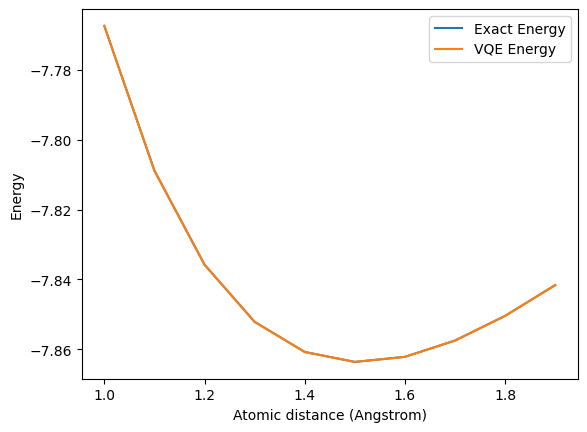

In [18]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

## Determine parameters from AS optimized solution for one distance

### SLSPQ

In [28]:
converge_counts = []
converge_values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    converge_counts.append(eval_count)
    converge_values.append(mean)

In [29]:
distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=30)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_as(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
        callback=store_intermediate_result
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )
    print(vqe_calc)

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.6 VQE Result: -7.86213 Exact Energy: -7.86213
{   'aux_operators_evaluated': None,
    'cost_function_evals': 20,
    'eigenvalue': -1.0581165068367442,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x7f940fbbad10>,
    'optimal_parameters': {   ParameterVectorElement(t[1]): -0.006715125084547058,
                              ParameterVectorElement(t[0]): -0.006715296769581318,
                              ParameterVectorElement(t[2]): -0.020047248332528102},
    'optimal_point': array([-0.0067153 , -0.00671513, -0.02004725]),
    'optimal_value': -1.0581165068367442,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x7f940f525c00>,
    'optimizer_time'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


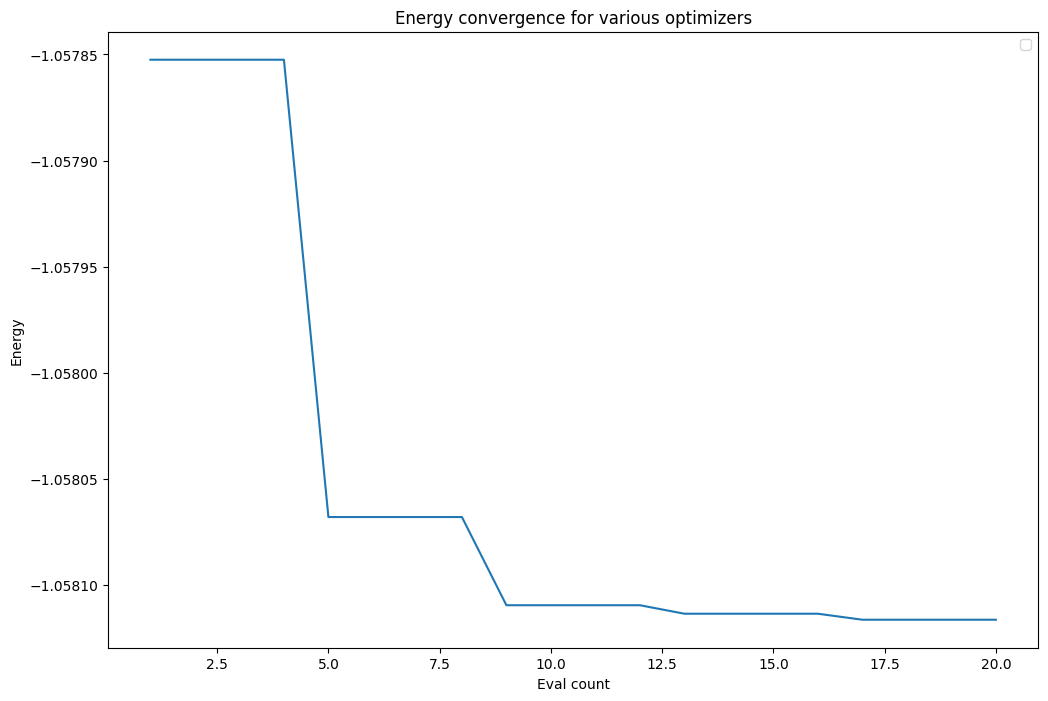

In [30]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(converge_counts, converge_values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

### SPSA

In [31]:
converge_counts = []
converge_values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    converge_counts.append(eval_count)
    converge_values.append(mean)

In [32]:
from qiskit_algorithms.optimizers import SPSA
distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SPSA(maxiter=100)
noiseless_estimator = AerEstimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_as(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    print(f"Qubits needed in ansatz: {var_form.num_qubits}")
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
        callback=store_intermediate_result
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )
    print(vqe_calc)

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Interatomic Distance: 1.6 VQE Result: -7.85783 Exact Energy: -7.86213
{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -1.0538148821897513,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x7f942c17bc40>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): -3.2939958164200216,
                              ParameterVectorElement(t[2]): -3.1667166402391227,
                              ParameterVectorElement(t[1]): -3.084434505501485},
    'optimal_point': array([-3.29399582, -3.08443451, -3.16671664]),
    'optimal_value': -1.0538148821897513,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x7f94806eec50>,
    'optimizer_time': 0.46

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


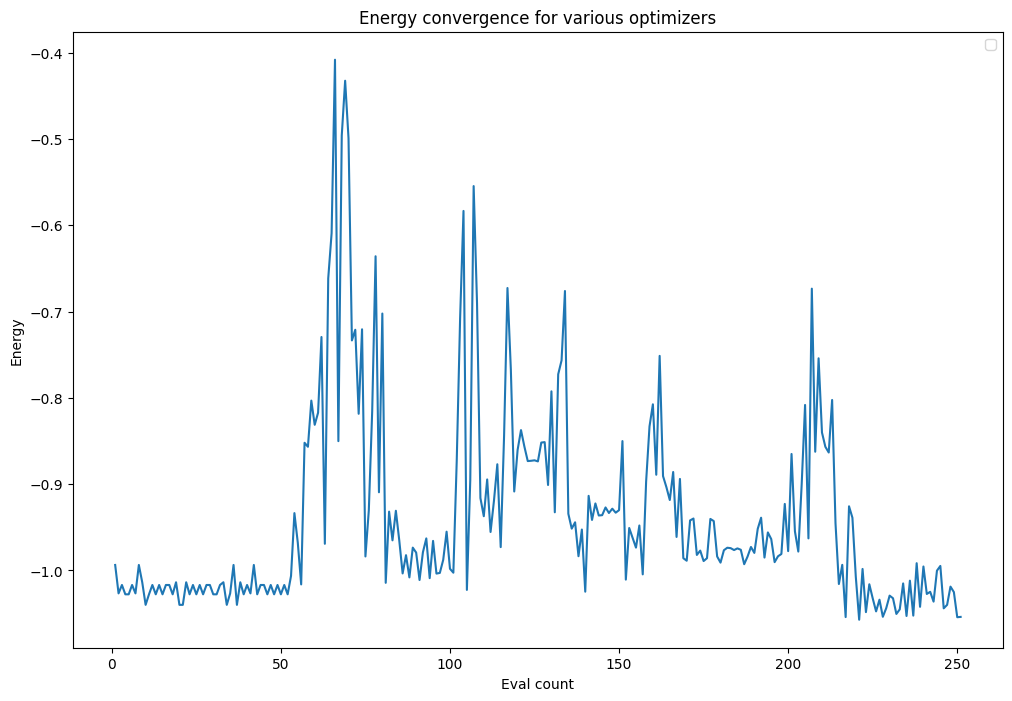

In [33]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(converge_counts, converge_values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

## run on hw (without zne)

In [42]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit.primitives import StatevectorEstimator

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=127)

In [39]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [40]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=100)
estimator = Estimator(backend)

# pylint: disable=undefined-loop-variable,line-too-long
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_as(1.6)

result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD(
    num_spatial_orbitals, num_particles, mapper, initial_state=init_state
)

print(f"Qubits needed in ansatz: {var_form.num_qubits}")
print(f"Parameters needed in ansatz: {var_form.num_parameters}")

#now convert to hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(var_form) 
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

x0 = initial_point=[0] * var_form.num_parameters

with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )


print(
    f"Interatomic Distance: {np.round(dist, 2)}",
    f"Exact Energy: {exact_energies[-1]:.5f}",
)

print("All energies have been calculated")

Problem spatial orbitals 6
Problem particles (2, 2)
FC-Problem spatial orbitals 5
FC-Problem particles (1, 1)
AS-Problem spatial orbitals 2
AS-Problem particles (1, 1)
Qubits needed in ansatz: 2
Parameters needed in ansatz: 3


/tmp/ipykernel_90709/2101555837.py:37: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## run on hw (with zne)

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Batch
options_ex6 = EstimatorOptions()
options_ex6.default_shots = default_shots
options_ex6.optimization_level = 0
options_ex6.resilience_level = 2
options_ex6.default_shots = default_shots
options_ex6.dynamical_decoupling.enable=True
options_ex6.dynamical_decoupling.sequence_type= "XX"
options_ex6.twirling.enable_measure=True
options_ex6.twirling.enable_gates=True
options_ex6.resilience.zne_mitigation=True
options_ex6.resilience.measure_mitigation=True
options_ex6.resilience.zne.extrapolator=('linear', 'exponential')
options_ex6.resilience.zne.noise_factors=(1,3,5)

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = [1.6]
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
#estimator = StatevectorEstimator()

# pylint: disable=undefined-loop-variable,line-too-long
(qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(1.6)

result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies[0].real)
init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
var_form = UCCSD(
    num_spatial_orbitals, num_particles, mapper, initial_state=init_state
)

print(f"Qubits needed in ansatz: {var_form.num_qubits}")
print(f"Parameters needed in ansatz: {var_form.num_parameters}")

#now convert to hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)

ansatz_isa = pm.run(var_form) 
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

x0 = initial_point=[0] * var_form.num_parameters

estimator = Estimator(backend=backend, options=options_ex6)
estimator.options.default_shots = 1000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
)


print(
    f"Interatomic Distance: {np.round(dist, 2)}",
    f"Exact Energy: {exact_energies[-1]:.5f}",
)

print("All energies have been calculated")

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()